---

<center> <h1> House Prices - Advanced Regression Techniques </h1> </center>
<br>

---


In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
from scipy.stats import norm, skew
from scipy.special import boxcox1p
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, r2_score

---
##### Data Wrangling, Exploration and EDA

In [31]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

In [32]:
df_train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [33]:
df_train.dtypes.array

<PandasArray>
[  dtype('int64'),   dtype('int64'),       dtype('O'), dtype('float64'),
   dtype('int64'),       dtype('O'),       dtype('O'),       dtype('O'),
       dtype('O'),       dtype('O'),       dtype('O'),       dtype('O'),
       dtype('O'),       dtype('O'),       dtype('O'),       dtype('O'),
       dtype('O'),   dtype('int64'),   dtype('int64'),   dtype('int64'),
   dtype('int64'),       dtype('O'),       dtype('O'),       dtype('O'),
       dtype('O'),       dtype('O'), dtype('float64'),       dtype('O'),
       dtype('O'),       dtype('O'),       dtype('O'),       dtype('O'),
       dtype('O'),       dtype('O'),   dtype('int64'),       dtype('O'),
   dtype('int64'),   dtype('int64'),   dtype('int64'),       dtype('O'),
       dtype('O'),       dtype('O'),       dtype('O'),   dtype('int64'),
   dtype('int64'),   dtype('int64'),   dtype('int64'),   dtype('int64'),
   dtype('int64'),   dtype('int64'),   dtype('int64'),   dtype('int64'),
   dtype('int64'),       dtype('O'), 

---

### Exploring the target variable:

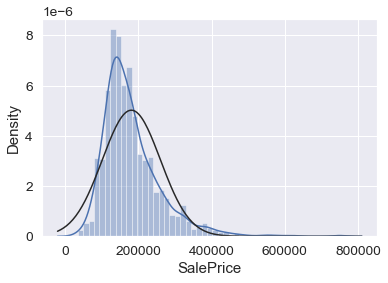

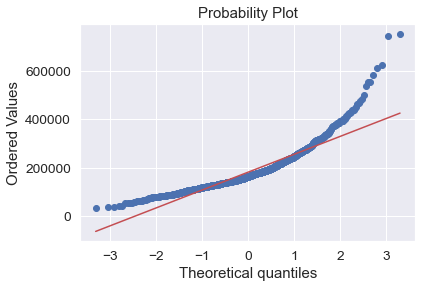

In [34]:
sns.distplot(df_train['SalePrice'] , fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['SalePrice'], plot=plt)
plt.show()

- The Target Variable is'nt normally distributed. It needs to be transformed using logarithmic transform

In [35]:
df_train["SalePrice"] = np.log1p(df_train["SalePrice"])

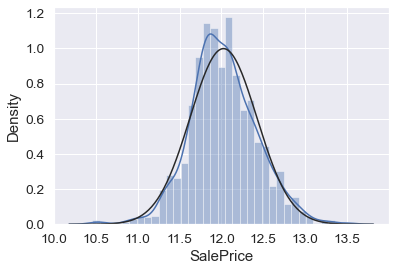

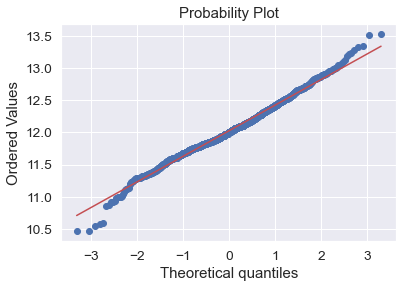

In [36]:
sns.distplot(df_train['SalePrice'] , fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['SalePrice'], plot=plt)
plt.show()

---
I'm going to inspect the meaning of every feature Philosophically, In order to get an intuition about the importance of every feature related to this problem.
- OverallQual.
- YearBuilt.
- TotalBsmtSF.
- GrLivArea.
- GarageCars.
- FullBath
I think this Variables are going to be Important, 

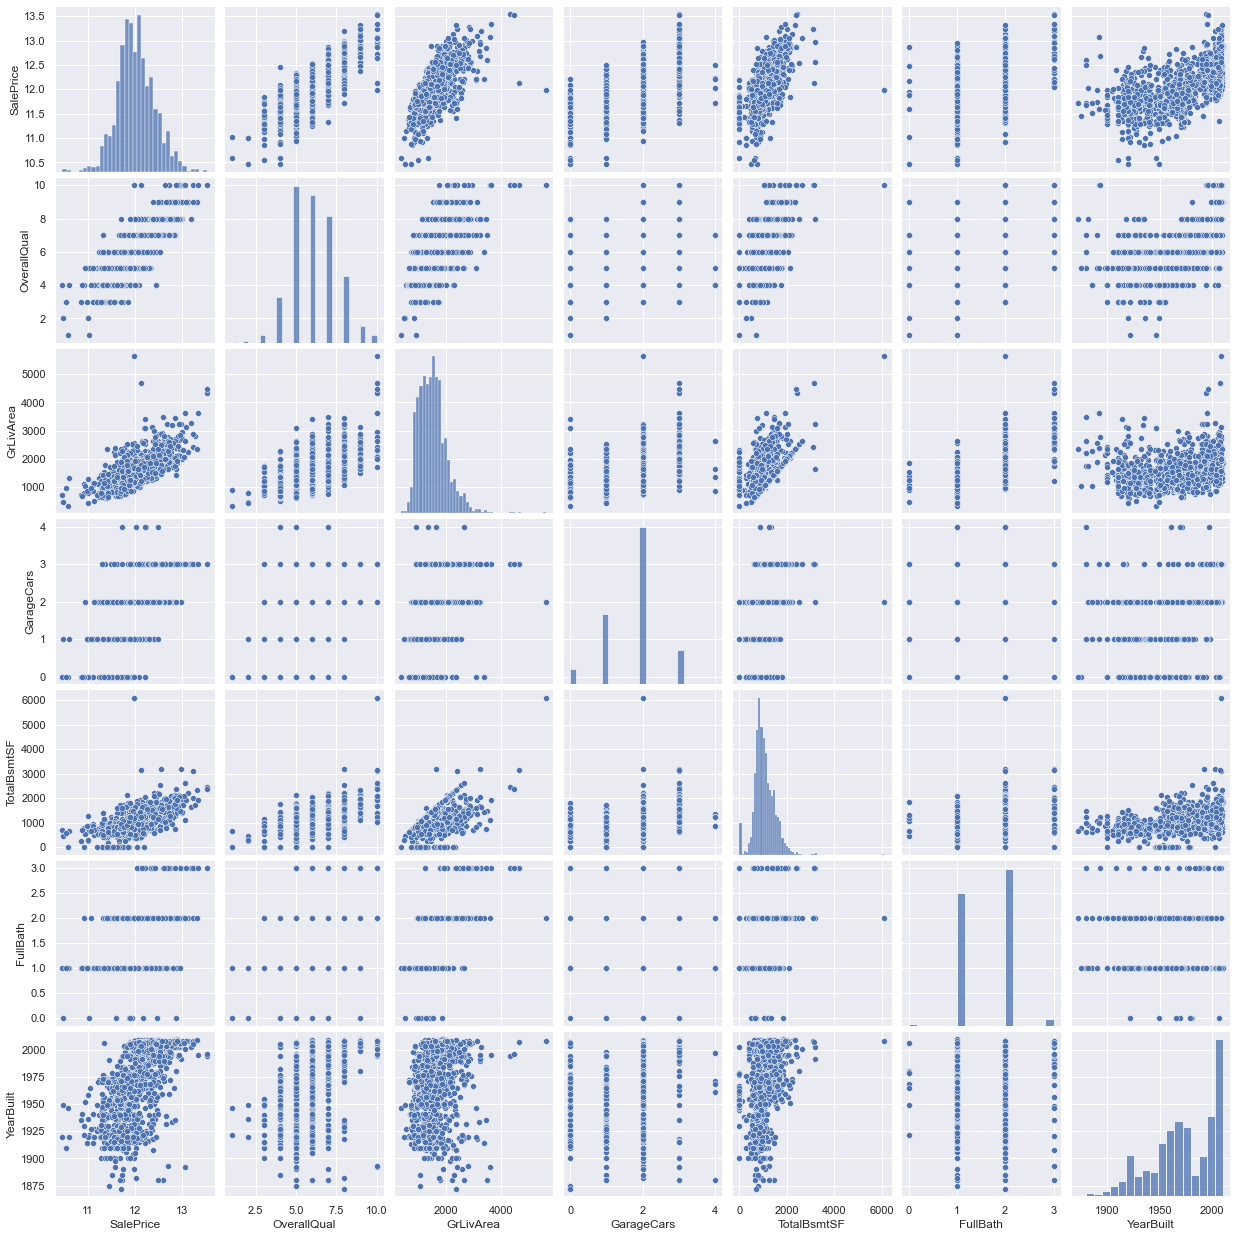

In [37]:
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(df_train[cols], size = 2.5)
plt.show();

- #### The Paireplot helps me to distinguish the distribution of variable itself, and the relationships among variables.
---

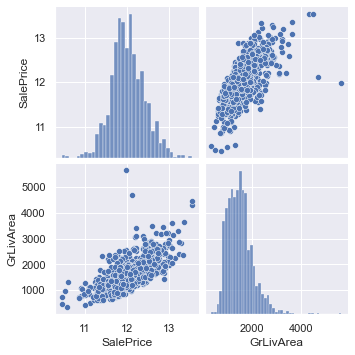

In [38]:
sns.pairplot(df_train[["SalePrice", 'GrLivArea']])

- Removing OutLiers

In [39]:
df_train.drop(df_train[(df_train['GrLivArea']>4000) & (df_train['SalePrice']<300000)].index, inplace=True)

In [40]:
corrmat = df_train.corr()

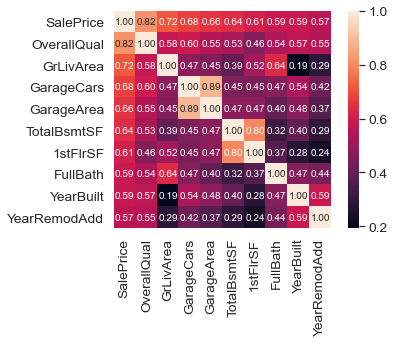

In [41]:
k = 10
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, 
                 square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [42]:
target = df_train.SalePrice.copy()

---

##### Missing Data:

- I need to inspect each variable and read its description in order to determine the Imputing type.

In [43]:
df = pd.concat((df_train, df_test)).reset_index(drop=True)
df.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(df.shape))

all_data size is : (2915, 80)


In [44]:
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum() / df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,2907,0.997256
MiscFeature,2810,0.963979
Alley,2717,0.932075
Fence,2345,0.804460
FireplaceQu,1420,0.487136
LotFrontage,486,0.166724
GarageCond,159,0.054545
GarageQual,159,0.054545
GarageYrBlt,159,0.054545
GarageFinish,159,0.054545


##### Imputing Missing data:

- for those columns, it appeares in the description that it has the `No` value, which means as an examble the house doesn't have a Pool or Alley.

- for the numerical variables, specifically when it comes to the `garage`, if the house has no garage i will impute it relevent variables with 0. Same for `Basement`.

- `MasVnrArea` and `MasVnrType` : NA most likely means no masonry veneer for these houses. 

In [45]:
for col in ["PoolQC", "MiscFeature", "Alley", "Fence", "FireplaceQu"] :
    df[col] = df[col].fillna("No")

In [46]:
for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    df[col] = df[col].fillna('No')

In [47]:
for col in ['GarageYrBlt', 'GarageArea', 'GarageCars']:
    df[col] = df[col].fillna(0)

In [48]:
for col in ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']:
    df[col] = df[col].fillna(0)

In [49]:
for col in ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']:
    df[col] = df[col].fillna('No')

In [50]:
df["MasVnrType"] = df["MasVnrType"].fillna("None")
df["MasVnrArea"] = df["MasVnrArea"].fillna(0)

<AxesSubplot:>

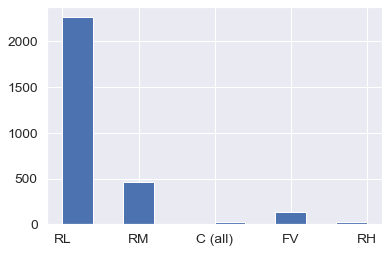

In [51]:
df.MSZoning.hist()

- I'm going to fill the `MSZoning` with `RL` the most frequent value.

In [52]:
df['MSZoning'] = df['MSZoning'].fillna(df['MSZoning'].mode()[0])

- it appeares that the missing value in `Functional` has the value Typical

In [53]:
df["Functional"] = df["Functional"].fillna("Typ")

- the area of each street connected to the house property most likely have a similar area to other houses in its neighborhood , i can fill the missing values by the median LotFrontage of the neighborhood.

In [54]:
df["LotFrontage"] = df.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

In [55]:
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum() / df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
Utilities,2,0.000686
KitchenQual,1,0.000343
Exterior1st,1,0.000343
Exterior2nd,1,0.000343
SaleType,1,0.000343
Electrical,1,0.000343
BsmtFinSF1,0,0.000000
BsmtFinType1,0,0.000000
BsmtExposure,0,0.000000
BsmtCond,0,0.000000


- The Remaining features has only 1 or 2 Na values, so i dropped them.

In [56]:
df['KitchenQual'] = df['KitchenQual'].fillna(df['KitchenQual'].mode()[0])

In [57]:
df['MSSubClass'] = df['MSSubClass'].fillna("No")
df['Exterior1st'] = df['Exterior1st'].fillna(df['Exterior1st'].mode()[0])
df['Exterior2nd'] = df['Exterior2nd'].fillna(df['Exterior2nd'].mode()[0])
df['Electrical'] = df['Electrical'].fillna(df['Electrical'].mode()[0])

In [58]:
df.drop(["Utilities"], axis=1, inplace=True)

---
##### Changing the dtypes & encoding

In [59]:
for col in ["MSSubClass", "OverallCond", "YrSold", "MoSold"]:
    df[col] = df[col].apply(str)

- Ordinal Encoding for some variables 

In [ ]:
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')

for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(df[c].values)) 
    df[c] = lbl.transform(list(df[c].values))

In [60]:
df.shape

(2915, 79)

In [87]:
StandardScaler

sklearn.preprocessing._data.StandardScaler

- Check Skewness:

In [61]:
numeric_feats = df.dtypes[df.dtypes != "object"].index
skewed_feats = df[numeric_feats].apply(lambda x: skew(x)).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' : skewed_feats})
skewness.head(10)

,Skew
MiscVal,21.932147
PoolArea,18.701829
LotArea,13.123758
LowQualFinSF,12.080315
3SsnPorch,11.368094
KitchenAbvGr,4.298845
BsmtFinSF2,4.142863
EnclosedPorch,4.000796
ScreenPorch,3.943508
BsmtHalfBath,3.942892


- Applying one of the most powerfull transformation methods `Box-Cox transformation`

In [62]:
skewed_features = skewness.index
lam = 0.15
for col in skewed_features:
    df[col] = boxcox1p(df[col], lam)

In [63]:
df.shape

(2915, 79)

---
Applying One-Hot Encoding:

In [64]:
df.drop(["Id"], axis=1, inplace=True)

In [65]:
df = pd.get_dummies(df)

In [66]:
df.shape

(2915, 336)

In [92]:
train = df[:df_train.shape[0]]
test = df[df_train.shape[0]:]

In [95]:
train.shape

(1456, 336)

In [96]:
test.shape

(1459, 336)

In [37]:
num_vars = train.select_dtypes(include=['int64','float64']).columns

In [38]:
scaler = StandardScaler()
train[num_vars] = scaler.fit_transform(train[num_vars])
test[num_vars] = scaler.transform(test[num_vars])

---

### Training Models:

In [93]:
train.shape

(1456, 336)

In [39]:
X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=0.2, random_state=42)

---
### Trying  Ridge Regression:

In [40]:
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
                 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
                 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100]
         }


ridge = Ridge()

folds = 5
model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_squared_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)    

model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 26 candidates, totalling 130 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 130 out of 130 | elapsed:    2.1s finished


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=1)

In [41]:
ridge = model_cv.best_estimator_

In [54]:
ridge

Ridge(alpha=20)

In [42]:
y_train_pred_ridge = ridge.predict(X_train)
print(r2_score(y_true=y_train, y_pred=y_train_pred_ridge))

0.9373187358598052


In [43]:
y_test_pred_ridge = ridge.predict(X_test)
print(r2_score(y_true=y_test, y_pred=y_test_pred_ridge))

0.9071329515522366


In [44]:
print ('RMSE Validation is: \n', mean_squared_error(y_test, y_test_pred_ridge))

RMSE Validation is: 
 0.014667279857542213


---

### Trying Lasso Regression

In [45]:
params = {'alpha': [0.00005, 0.0001, 0.001, 0.008, 0.01]}
lasso = Lasso()

model_cv_l = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_squared_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

model_cv_l.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.8s finished


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [5e-05, 0.0001, 0.001, 0.008, 0.01]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=1)

In [46]:
lasso = model_cv_l.best_estimator_

In [47]:
y_train_pred_lasso = lasso.predict(X_train)
print(r2_score(y_true=y_train, y_pred=y_train_pred_lasso))

0.9314932638688753


In [48]:
y_test_pred_lasso = lasso.predict(X_test)
print(r2_score(y_true=y_test, y_pred=y_test_pred_lasso))

0.9053962604610747


In [55]:
X_test.shape

(292, 219)

In [56]:
test.shape

(1459, 219)

----

### Preparing submission:

In [50]:
preds = np.exp(ridge.predict(test))

In [51]:
predictions = pd.DataFrame({'Id': df_test['Id'] ,'SalePrice': preds })

In [52]:
predictions.to_csv("preds.csv",index=False)

In [53]:
predictions.SalePrice

0       116228.506408
1       155733.849045
2       181324.042705
3       192517.325108
4       190389.584537
            ...      
1454     85492.716876
1455     81710.933270
1456    169910.576369
1457    121431.552289
1458    223529.422606
Name: SalePrice, Length: 1459, dtype: float64